In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp trait

## Trait
> contains logic for quantitative traits

In [ ]:
#|export

from chewc.core import *
import torch
import attr
from typing import Tuple, Optional, List
from fastcore.test import *
import matplotlib.pyplot as plt
import torch.nn as nn
import pdb

def select_qtl_loci(num_qtl_per_chromosome: int, genome: Genome) -> torch.Tensor:
    """
    Randomly selects loci to be QTLs on each chromosome.

    Args:
    ----
    num_qtl_per_chromosome (int): Number of QTLs to select per chromosome.
    genome (Genome): Genome object containing the chromosome structure.
    device (str): Device to create the tensor on ('cpu' or 'cuda'). Defaults to 'cpu'.

    Returns:
    -------
    torch.Tensor: A boolean tensor indicating which loci are QTLs. 
                  Shape: (number_chromosomes, loci_per_chromosome)
    """
    
    assert num_qtl_per_chromosome <= genome.n_loci_per_chromosome, "too many qtls for this trait given your Genome object"
    assert num_qtl_per_chromosome > 0, "you need at least 1 QTL per chromosome"
    
    qtl_indices = []
    for i in range(genome.n_chromosomes):
        # Randomly sample indices for QTLs on the current chromosome
        chromosome_indices = torch.randperm(genome.n_loci_per_chromosome)[:num_qtl_per_chromosome]
        
        # Create a boolean tensor for the current chromosome, marking QTL positions as True
        chromosome_qtl_flags = torch.zeros(genome.n_loci_per_chromosome, dtype=torch.bool)
        chromosome_qtl_flags[chromosome_indices] = True
        
        qtl_indices.append(chromosome_qtl_flags)
    
    return torch.stack(qtl_indices)



In [ ]:
import torch

ploidy = 2
n_chr = 10
n_loci = 100
n_Ind = 333
g = Genome(ploidy, n_chr, n_loci)
population = Population()
population.create_random_founder_population(g, n_founders=n_Ind)
init_pop = population.get_dosages().float()  # gets allele dosage for calculating trait values

# Trait A Class
target_means = torch.tensor([0, 5, 20])
target_vars = torch.tensor([1, 1, 0.5])  # Note: I'm assuming you want a variance of 1 for the second trait
n_traits = target_means.shape[0]
correlation_values = [
    [1.0, 0.2, 0.58],
    [0.2, 1.0, -0.37],
    [0.58, -0.37, 1.0],
]

corA = torch.tensor(correlation_values)
L = torch.linalg.cholesky(corA)

# Sample initial additive effects from a standard normal distribution
uncorrelated_effects = torch.randn(n_chr, n_loci, n_traits)

# Reshape for proper multiplication with Cholesky factor
uncorrelated_effects = uncorrelated_effects.reshape(n_chr * n_loci, n_traits)

# Introduce correlation FIRST
correlated_effects = torch.matmul(L, uncorrelated_effects.T).T
correlated_effects = correlated_effects.reshape(n_chr, n_loci, n_traits)

# Calculate unscaled breeding values using CORRELATED effects
unscaled_bvs = torch.einsum('ijk,lij->lk', correlated_effects, init_pop)
unscaled_var = unscaled_bvs.var(dim=0)
unscaled_mean = unscaled_bvs.mean(dim=0)
trait_intercepts = []

# Scale correlated effects and calculate intercepts
for i in range(n_traits):
    scaling_factor = torch.sqrt(target_vars[i] / unscaled_var[i])
    correlated_effects[:, :, i] *= scaling_factor  # Scale the CORRELATED effects
    trait_intercepts.append(target_means[i] - (unscaled_mean[i] * scaling_factor))

# Now we have the additive marker effects and intercepts to calculate breeding values
trait_intercepts = torch.tensor(trait_intercepts)
scaled_bvs = torch.einsum('ijk,lij->lk', correlated_effects, init_pop)

Created genetic map


In [ ]:
class TraitA(nn.Module):
    def __init__(self, genome: Genome, effects: torch.Tensor, intercept: float):
        """
        Initialize the TraitA model.

        Args:
            genome (Genome): The genome object containing the genomic architecture.
            effects (torch.Tensor): The QTL effects tensor. Shape: (n_chromosomes, n_loci_per_chromosome).
            intercept (float): The intercept value for the trait model.
        """
        super().__init__()
        self.genome = genome
        self.effects = effects.to(genome.device)
        self.intercept = intercept

    def forward(self, dosages: torch.Tensor, h2: Optional[float] = None, varE: Optional[float] = None) -> torch.Tensor:
        """
        Forward pass to calculate the breeding values with optional environmental noise.

        Args:
            dosages (torch.Tensor): The dosage tensor. Shape: (population_size, n_chromosomes, n_loci_per_chromosome).
            h2 (float, optional): Heritability of the trait. If provided, environmental noise is added based on h2.
            varE (float, optional): Environmental variance. If provided, environmental noise is added based on varE.

        Returns:
            torch.Tensor: The calculated breeding values with optional environmental noise.
        """
        # Calculate breeding values
        breeding_values = torch.einsum('ijk,jk->i', dosages, self.effects) + self.intercept

        
        if varE is not None:
            # Add environmental noise based on environmental variance
            env_noise = torch.randn_like(breeding_values) * torch.sqrt(torch.tensor(varE))
            breeding_values += env_noise
        elif h2 is not None:
            # Calculate environmental variance from heritability
            varG = breeding_values.var(unbiased=False)
            varE = varG * (1 - h2) / h2
            env_noise = torch.randn_like(breeding_values) * torch.sqrt(varE)
            breeding_values += env_noise

        return breeding_values

In [ ]:

ta = TraitA(g, correlated_effects[:,:,0], trait_intercepts[0])
tb = TraitA(g, correlated_effects[:,:,1], trait_intercepts[1])
tc = TraitA(g, correlated_effects[:,:,2], trait_intercepts[2])

ta_values = ta(init_pop,h2=1)
tb_values = tb(init_pop,h2=1)
tc_values = tc(init_pop,h2=.2)

<matplotlib.collections.PathCollection>

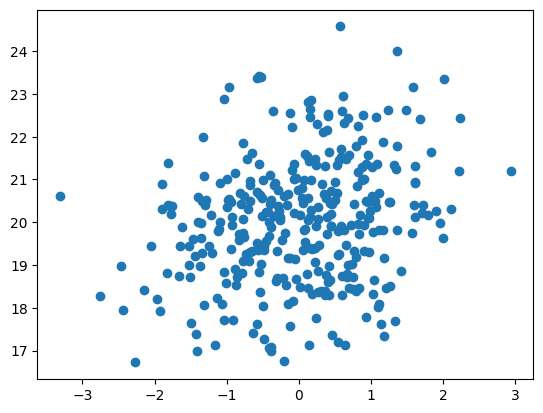

In [ ]:
plt.scatter(ta_values, tc_values)

<matplotlib.collections.PathCollection>

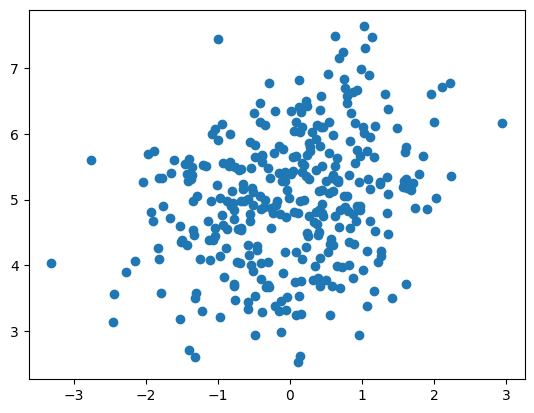

In [ ]:
plt.scatter(ta_values,tb_values)

<matplotlib.collections.PathCollection>

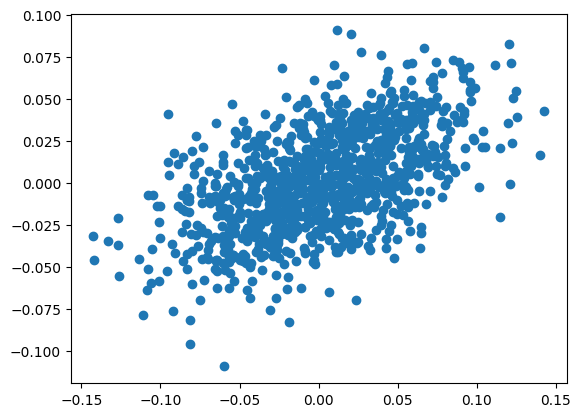

In [ ]:
plt.scatter(correlated_effects[:,:,0],correlated_effects[:,:,2])

<matplotlib.collections.PathCollection>

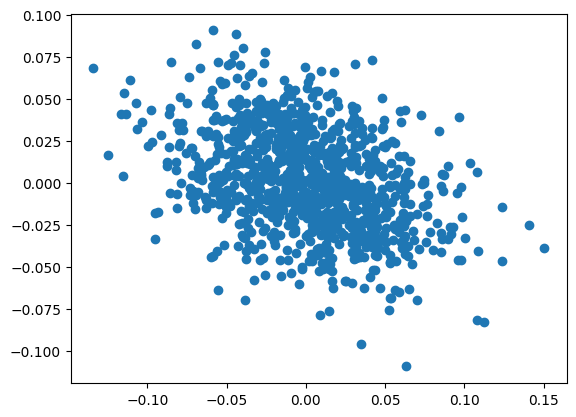

In [ ]:
plt.scatter(correlated_effects[:,:,1],correlated_effects[:,:,2])

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()